In [3]:
import numpy as np
import networkx as nx
import time
%matplotlib notebook
import matplotlib.pyplot as plt
%pylab inline
import sys
sys.setrecursionlimit(30000)

Populating the interactive namespace from numpy and matplotlib


## Генераторы графов

In [4]:
# функция возвращает случайный простой граф в моделе Gnp 
# вероятность ребра p = 2*m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnp_graph(n, m, seed=45):
    
    edge_p = 2*m/(n*(n-1))
    g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed)
  
    return nx.convert.to_dict_of_lists(g)

In [5]:
# функция возвращает случайный ориентированный граф в моделе Gnp 
# вероятность ребра p = m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_Gnp_digraph(n, m, seed=42):
    edge_p = m/(n*(n-1))
    g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed,True)

    return nx.convert.to_dict_of_lists(g)

In [6]:
# функция возвращает случайный простой граф в моделе Gnm 
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnm_graph(n, m, seed=42):
    g = nx.random_graphs.gnm_random_graph(n,m,seed)

    return nx.convert.to_dict_of_lists(g)

In [7]:
# функция возвращает случайный ориентированный граф в моделе Gnm
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_Gnm_digraph(n, m, seed=42):
    g = nx.random_graphs.gnm_random_graph(n,m,seed,True)

    return nx.convert.to_dict_of_lists(g)

In [8]:
# функция возвращает связный ориентированный Ейлеров граф
# в графе n вершин, k - параметр, от которого зависти генерация
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_Euler_digraph(n, k=8):
    in_degs, out_degs = [k]*n, [k]*n 
    G = nx.generators.directed_havel_hakimi_graph(in_degs, out_degs)
    WCCs = list(nx.algorithms.components.weakly_connected_components(G))
    if len(WCCs) > 1:
        connecting_nodes = []
        for WCC in WCCs:
            some_vertex_of_WCC = next(iter(WCC))
            connecting_nodes.append(some_vertex_of_WCC)
        for i in range(1, len(connecting_nodes)):
            G.add_edge(connecting_nodes[i-1],connecting_nodes[i])
            G.add_edge(connecting_nodes[i],connecting_nodes[i-1])
    
    return nx.convert.to_dict_of_lists(G)

In [9]:
# утилитарная функция, переводящая таплы вида (1, 0, 0, 1)
# в числа, интерпетируя эту запись как число в двоичной записи
# эта функция нужна для следующей функции
def get_index_from_binary(tup):
    n = len(tup)
    mult = 1
    res = 0
    for i in range(n):
        res += tup[i]*mult
        mult *= 2
    return res

# функция возвращает связный ориентированный регулярный Ейлеров граф
# входные и выходные степени всех вершин совпадают и равны half_dim
# число вершин равно 4**half_dim
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_hypercube_digraph(half_dim):
    G = nx.generators.hypercube_graph(half_dim*2)
    directed_G = nx.DiGraph()
    Euler_circuit_G = nx.algorithms.eulerian_circuit(G)
    for (u,v) in Euler_circuit_G:
        directed_G.add_edge(get_index_from_binary(u), get_index_from_binary(v))
    return nx.convert.to_dict_of_lists(directed_G)

#Алгоритмы сортировки

In [10]:
# поразрядная сортировка
# возвращает итоговую перестановку эелементов массива A
# для того, чтобы можно было переставить элементы в любом другом массиве\


# as default, 64 bit number divides on 4 parts of 16 bit
def radix_argsort(weights, divide_for=4):
    num_of_bits_per_iter = int(64 / divide_for)
    if len(weights) == 0:
        alpha = np.uint64(0)
    else:
        alpha = max(weights)[0]

    max_2byte = 0

    while (alpha >> np.uint64(max_2byte * num_of_bits_per_iter)):
        max_2byte += 1

    copy = weights
    for num in range(max_2byte):
        copy = counting_sort(copy, num_of_bits_per_iter, num)
    return copy


def counting_sort(array, bits, iter):
    C = [0 for i in range(2**bits)]
    R = [0 for i in range(len(array))]

    mask = np.uint64(2**bits - 1)

    length = len(array)

    for i in range(length):
        C[(np.uint64(array[i][0]) >> np.uint64(iter * bits)) & mask] += 1

    for i in range(1, len(C)):
        C[i] += C[i - 1]

    for i in range(length):
        C[(np.uint64(array[i][0]) >> np.uint64(iter * bits)) & mask] -= 1
        R[C[(np.uint64(array[i][0]) >> np.uint64(iter * bits))
            & mask]] = array[i]

    return R

In [11]:
# карманная сортировка
# возвращает итоговую перестановку эелементов массива A
# для того, чтобы можно было переставить элементы в любом другом массиве
def bucket_argsort(labels):
    n = len(labels)
    if (n == 0):
        return
    maximum = max(labels)[0]
    bucket = [[] for i in range(n)]
    bucket_range = maximum / n

    for i in range(n):
        if (labels[i][0] == 0):
            bucket_index = 0
        else:
            bucket_index = (int)(labels[i][0] / bucket_range)
        if bucket_index != n:
            bucket[bucket_index].append(labels[i])
        else:
            bucket[bucket_index - 1].append(labels[i])

    for i in range(len(bucket)):
        bucket[i] = insertion_argsort(bucket[i])
    index = 0
    R = [0 for i in range(n)]
    for i in range(n):
        for j in range(len(bucket[i])):
            R[index] = bucket[i][j]
            index += 1
    return R

In [12]:
# быстрая сортировка
from random import randint


def quick_argsort(labels, low, high):
    while (high - low >= 200):
        part = partition(labels, low, high)  # index
        if (part - low <= high - pi - 1):  # choose the least part
            quickSort(labels, low, part - 1)
            low = part + 1
        else:
            quickSort(labels, part + 1, high)
            high = part
    insertion_argsort(labels)


def partition(labels, low, high):
    i = low - 1
    rand_index = randint(low, high)  # random elem lambda
    alpha = labels[rand_index]  #lambda

    for k in range(low, high):
        if (labels[k] < alpha):  # lower part
            i += 1
            labels[i], labels[k] = labels[k], labels[i]
        elif (labels[k] == alpha):  # equal part
            i += 1
            labels[i], labels[k] = labels[k], labels[i]

    labels[i + 1], labels[rand_index] = labels[rand_index], labels[i + 1]
    return i + 1


def insertion_argsort(labels):
    for i in range(1, len(labels)):
        temp = labels[i]
        j = i - 1
        while j >= 0 and labels[j] > temp:
            labels[j + 1] = labels[j]
            j -= 1
        labels[j + 1] = temp
    return labels

#Алгоритмы для поиска мостов

In [13]:
# детерминированный алгоритм для поиска мостов
# на вход поступает граф представленный списком смежности
# саписок представлен как словарь(хеш-таблица) списков
# выход представляет собой список ребер, являющихся мостами 
class dfs_bridges:
    def __init__(self, Graph):
        self.Graph = Graph
        self.color = ["white" for i in range(len(Graph))]
        self.tin = [np.inf for i in range(len(Graph))]
        self.low = [np.inf for i in range(len(Graph))]
        self.one_bridges = []
        self.timer = 0
        
    def dfs(self, graph, v, p = -1):
        self.color[v] = "gray"
        self.tin[v]=self.low[v] = self.timer
        self.timer += 1
        for u in list(self.Graph[v]):
            if (u == p):
                continue
            if (self.color[u] == "white"):
                self.dfs(graph, u, v)
                self.low[v] = min(self.low[v], self.low[u])
                if (self.low[u] > self.tin[v]):
                    if (u > v):
                        self.one_bridges.append( (v, u) )
                    else:
                        self.one_bridges.append( (u, v) )   
            else:
                self.low[v] = min(self.low[v], self.tin[u])
        self.color[v] = "black"
            
def compute_bridges_determ(adj_list):
    test = dfs_bridges(adj_list)
    for i in range(len(test.Graph)):
        if (test.color[i] == "white"):
            test.dfs(test.Graph, i)
    return set(test.one_bridges)

In [14]:
def draw_grapgh(G):
    G = nx.Graph(G)
    pos = nx.spring_layout(G)
    nx.draw(G,pos)
    nx.draw_networkx_labels(G,pos,font_color='white',font_weight='bold')
    plt.draw()
    plt.show()
    return

In [15]:
import random
# рандомизированный алгоритм для поиска мостов
# на вход поступает граф представленный списком смежности
# саписок представлен как словарь(хеш-таблица) списков 
# выход представляет собой список ребер, являющихся мостами с большой вероятностью
# Randomized Bridge Search
class random_bridges:
    def __init__(self, Graph):
        self.G = nx.Graph(Graph)
        self.visited = ['white' for i in range(len(Graph))] 
        self.stack = []
        self.labeled_edge_list = []
        self.bit = 64
    
    def rand_dfs(self, v):
        self.visited[v] = 'gray'
        self.stack.append(v)
        
        for u in list(self.G.adj[v].keys()):
            if (self.visited[u] == 'white'):
                self.G[v][u]['label'] = 'ostov'
                self.rand_dfs(u)
            elif self.visited[u] == 'gray' and (len(self.stack) == 1 or u != self.stack[-2]):
                if 'weight' not in self.G[v][u]:
                    self.G[v][u]['weight'] = random.getrandbits(self.bit)
                    if (u > v):
                        self.labeled_edge_list.append([self.G[v][u]['weight'],
                                                      (v,u)])
                    else:
                        self.labeled_edge_list.append([self.G[v][u]['weight'],
                                                      (u,v)])
        self.stack.pop()
        self.visited[v] = 'black'
        u_weight = np.uint64(0)
                   
        if (len(self.stack) != 0):
            for t in list(self.G.adj[v].keys()):
                if 'weight' in self.G[v][t]:
                    u_weight = u_weight ^ np.uint64(self.G[v][t]['weight'])
            self.G[v][self.stack[-1]]['weight'] = u_weight
            if (v > self.stack[-1]):
                self.labeled_edge_list.append([u_weight, (self.stack[-1]
                                                          , v)])
            else:
                self.labeled_edge_list.append([u_weight, (v
                                                          , self.stack[-1])])
            
                
            
        
        
def compute_bridges_rand(G):
    rds = random_bridges(G)
    for i in range(len(G)):
        if (rds.visited[i] == 'white'):
            rds.rand_dfs(i)
    bridges = []
    for item in rds.labeled_edge_list:
        if (item[0] == 0):
            bridges.append(item[1])
        
    return bridges
    

In [16]:
# рандомизированный алгоритм для поиска 2-мостов
#
# на вход поступает граф представленный списком смежности и алгоритм сортировки для меток на ребрах
# саписок представлен как словарь(хеш-таблица) списков
#
# выходом алгоритма является список списков ребер
# в каждом списке любая пара ребер должна с высокой вероятностью образовывать 2-мост
# например, если выходом является спискок [[e1, e2, e3],[e4, e5]]
# то с высокой вероятностью 2-мостами будут пары ребер: (e1,e2), (e1,e3), (e2,e3), (e4,e5)
# ребра здесь это пары вершин типа e1 = (1,2)
def compute_1bridges(G):
    rds = random_bridges(G)
    for i in range(len(G)):
        if (rds.visited[i] == 'white'):
            rds.rand_dfs(i)
    return rds.labeled_edge_list


def compute_2bridges_rand(G, sort):
    labels = compute_1bridges(G)
    result = None
    if (sort == bucket_argsort):
        result = sort(labels)
    if (sort == radix_argsort):
        result = sort(labels)
    if (sort == quick_argsort):
        result = sort(labels, 0, len(labels))
    only_bridges = []
    if (result == None):
        return [[]]
    else:
        for i in range(len(result) - 1):
            if (result[i][0] == result[i + 1][0]):
                only_bridges.append([(result[i][1], result[i + 1][1])])
        return only_bridges

#Эйлеровы циклы

In [17]:
 def compute_Euler_circuit_digraph(adj_list):
        euler = euler_path(adj_list)
        euler.find_euler_path()
        return list(reversed(euler.euler_path))
    
        
class euler_path:
    def __init__(self, graph):
        self.graph = nx.DiGraph(graph)
        self.euler_path = []
        self.stack = []

    def find_euler_path(self, v = 0):
        self.stack.append(v) # add to stack initial vertex
        last_visited_vertex = None # last visited vertex (at first None)
        while len(self.stack) != 0: 
            curr_vertex = self.stack[-1] # top of the stack
            if len(list(self.graph.adj[curr_vertex])) == 0: # if degree of vertex is 0
                if (last_visited_vertex is not None): # if it is not the first vertex
                    self.euler_path.append((curr_vertex, last_visited_vertex)) # add edge to euler path
              # delete vertex from stack and replace last visited vertex
                last_visited_vertex = curr_vertex 
                self.stack.pop()
            else: # if there is some adjacent vertexes (degree > 0)
                next_vertex = random.choice(list(self.graph.adj[curr_vertex])) # pick one of them
                self.stack.append(next_vertex) # push to the stack
                self.graph.remove_edge(curr_vertex, next_vertex) # delete this edge (~ delete vertex from list)

# Арифметика в конечных кольцах и полях

In [18]:
# эта функция инвертирует x в Zp с помощью алгоритма Евклида
# выходом является целое число y, такое что
# 1) 0 < y < p 
# 2) (xy) mod p = 1 
# если число невозможно инвертировать, функция возвращает 0
def gcd_extended(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        div, x, y = gcd_extended(b % a, a)
    return (div, y - (b // a) * x, x)


def invert_in_Zp_Euclead(p,x):
    #a*x + m*y = 1 // a = 322 m = 2347
    div,z,y = gcd_extended(x, p)
    if (div != 1):
        return 0
    else:
        return (z%p + p) % p

In [19]:
# эта функция инвертирует x в Zp с помощью малой теоремы Ферма и алгоритма быстрого возведения в степень
# выходом является целое число y, такое что
# 1) 0 < y < p 
# 2) (xy) mod p = 1 
# если число невозможно инвертировать, функция возвращает 0
def binpow(a, n):
    if (n == 0):
        return 1
    if (n % 2 == 1):
        return binpow(a, n-1) * a
    else:
        b = binpow(a, n/2)
        return b*b
    
    
def gcd_simple(x,y):
    if (x == 0 or y == 0):
        return y
    return gcd_simple(y % x, x)


def invert_in_Zp_Ferma(p,x):
    if (gcd_simple(p, x) != 1):
        return 0
    return (binpow(x, p-2))%p

#Стресс тесты

In [20]:
def stress_test_bridges_determ(n, m, iterations_num=1000):
    for i in range(iterations_num):
        G = get_random_simple_Gnp_graph(n, m, i)
        briges_test = compute_bridges_determ(G)
        bridges_true = set(nx.algorithms.bridges(nx.Graph(G)))
        diff = list(bridges_true.symmetric_difference(briges_test))
        if len(diff) > 0:
            raise Exception(
                f"Неверное решение в детерминированном алгоритме поиска мостов, n: {n}, m: {m}, seed: {i}"
            )
    print(
        f"Стресс тест для детерминированного поиска мостов пройден!, n: {n}, m: {m}, iterations_num: {iterations_num}"
    )

In [21]:
def stress_test_bridges_rand(n, m, iterations_num=1000):
    exp_err = m * (1 / (2**64))
    for i in range(iterations_num):
        G = get_random_simple_Gnp_graph(n, m, i)
        briges_test = sorted(compute_bridges_rand(G))
        bridges_true = set(sorted(nx.algorithms.bridges(nx.Graph(G))))
        diff = list(bridges_true.symmetric_difference(briges_test))
        if len(diff) > exp_err:
            raise Exception(
                f"Число ошибок в рандомизированном алгоритме поиска мостов превышено, n: {n}, m: {m}, errors_num: {len(diff)}, seed: {i}"
            )
    print(
        f"Стресс тест для рандомизированного поиска мостов пройден!, n: {n}, m: {m}, iterations_num: {iterations_num}"
    )

In [22]:
def stress_test_finite_fields(p=2**61 - 1, iterations_num=100000):
    for i in range(iterations_num):
        x = numpy.random.randint(1, p)
        inverse_Euclead_x = invert_in_Zp_Euclead(p, x)
        inverse_Ferma_x = invert_in_Zp_Ferma(p, x)
        if (np.gcd(p, x) == 1):
            if (x * inverse_Euclead_x - 1) % p != 0:
                raise Exception(
                    f"Неправильное инвертирование алгоритмом Евклида, p: {p}, x: {x}"
                )
            if (x * inverse_Ferma_x - 1) % p != 0:
                raise Exception(
                    f"Неправильное инвертирование алгоритмом быстрого возведения в степень, p: {p}, x: {x}"
                )
        else:
            if inverse_Euclead_x != 0:
                raise Exception(
                    f"Неправильное инвертирование алгоритмом Евклида, p: {p}, x: {x}"
                )
            if inverse_Ferma_x != 0:
                raise Exception(
                    f"Неправильное инвертирование алгоритмом быстрого возведения в степень, p: {p}, x: {x}"
                )
    print(
        f"Стресс тест для арифметики в конечных полях пройден!, p: {p}, iterations_num: {iterations_num}"
    )

In [23]:
def stress_test_2bridges_rand(n, m, sort, iterations_num=1000):
    exp_err = (m * (m - 1) / 2) * (1 / (2**64))
    for iteration in range(iterations_num):
        err_num = 0
        G = nx.Graph(get_random_simple_Gnp_graph(n, m, iteration))
        bridges_test = compute_2bridges_rand(G, sort)
        for edge_group in bridges_test:
            for e1 in range(len(edge_group)):
                for e2 in range(e1 + 1, len(edge_group)):
                    G_with_deleted_2bridge = G.copy()
                    G_with_deleted_2bridge.remove_edge(*edge_group[e1])
                    G_with_deleted_2bridge.remove_edge(*edge_group[e2])
                    if nx.connected.number_connected_components(
                            G) == nx.connected.number_connected_components(
                                G_with_deleted_2bridge):
                        ++err_num
        if err_num > exp_err:
            raise Exception(
                f"Число ошибок в рандомизированном алгоритме поиска мостов превышено, n: {n}, m: {m}, errors_num: {err_num}, sort: {sort}, seed: {iteration}"
            )
    print(
        f"Стресс тест для рандомизированного поиска 2-мостов пройден!, n: {n}, m: {m}, , sort: {sort}, iterations_num: {iterations_num}"
    )

In [24]:
def test_Euler_circuit(G, test_circuit):
    edges_dict = {}
    m = 0
    for (v, neib) in G.items():
        for u in neib:
            edges_dict[(v, u)] = False
            m += 1

    l = len(test_circuit)
    if m != l:
        return False

    for i in range(1, m):
        if test_circuit[i - 1][1] != test_circuit[i][0]:
            return False
    if test_circuit[l - 1][1] != test_circuit[0][0]:
        return False

    for e in test_circuit:
        if edges_dict.get(e, True) == True:
            return False
        else:
            edges_dict[e] = True

    return True


# max_n должно быть строго больше чем 10
def stress_test_Euler_circuit_digraph(max_n, iterations_num=1000):
    for iteration in range(iterations_num):
        n = np.random.randint(10, max_n)
        k = np.floor(n / 4)
        G = get_Euler_digraph(n, k)
        test_circuit = compute_Euler_circuit_digraph(G)
        if not test_Euler_circuit(G, test_circuit):
            raise Exception(
                f"Неправильный Эйлеров обход, функция генерации: get_Euler_digraph, n: {n}, k: {k}"
            )
    print(
        f"Стресс тест для ориентированных Эйлеровых циклов пройден, max_n: {max_n}, iterations_num: {iterations_num}"
    )

 # Стресс тесты

In [ ]:
stress_test_Euler_circuit_digraph(10000, 10)

Стресс тест для ориентированных Эйлеровых циклов пройден, max_n: 10000, iterations_num: 10


In [ ]:
stress_test_bridges_determ(1000000,400000,10) #100 30 100
stress_test_bridges_rand(1000000,400000,10)
stress_test_finite_fields(2347, 1000)
stress_test_2bridges_rand(1000000,400000,radix_argsort,10)# 100 30 radix_argsort, 10
stress_test_2bridges_rand(1000000,400000,bucket_argsort,10)
stress_test_2bridges_rand(1000000,400000,quick_argsort,10)

Стресс тест для детерминированного поиска мостов пройден!, n: 1000000, m: 400000, iterations_num: 10
Стресс тест для рандомизированного поиска мостов пройден!, n: 1000000, m: 400000, iterations_num: 10
Стресс тест для арифметики в конечных полях пройден!, p: 2347, iterations_num: 1000
Стресс тест для рандомизированного поиска 2-мостов пройден!, n: 1000000, m: 400000, , sort: <function radix_argsort at 0x7f15a2764560>, iterations_num: 10
Стресс тест для рандомизированного поиска 2-мостов пройден!, n: 1000000, m: 400000, , sort: <function bucket_argsort at 0x7f15a22c8950>, iterations_num: 10
Стресс тест для рандомизированного поиска 2-мостов пройден!, n: 1000000, m: 400000, , sort: <function quick_argsort at 0x7f15a22c8050>, iterations_num: 10


# Юнит тесты

In [25]:
def finite_fields_unit_tests():
    assert (invert_in_Zp_Euclead(6, 4) == 0)
    assert (invert_in_Zp_Ferma(6, 4) == 0)

    assert (invert_in_Zp_Euclead(6, 2) == 0)
    assert (invert_in_Zp_Ferma(6, 2) == 0)

    assert (invert_in_Zp_Euclead(2347, 0) == 0)
    assert (invert_in_Zp_Ferma(2347, 0) == 0)

    assert (invert_in_Zp_Euclead(7, 6) == 6)
    assert (invert_in_Zp_Ferma(7, 6) == 6)

    assert (invert_in_Zp_Euclead(2347, 2346) == 2346)
    assert (invert_in_Zp_Ferma(2347, 2346) == 2346)

    assert (invert_in_Zp_Euclead(1, 0) == 0)
    assert (invert_in_Zp_Ferma(1, 0) == 0)

    assert (invert_in_Zp_Euclead(2, 0) == 0)
    assert (invert_in_Zp_Ferma(2, 0) == 0)

    assert (invert_in_Zp_Euclead(2, 1) == 1)
    assert (invert_in_Zp_Ferma(2, 1) == 1)

In [26]:
def bridges_unit_test(G):
    test_bridges_determ = compute_bridges_determ(
        nx.convert.to_dict_of_lists(G))
    test_bridges_rand = compute_bridges_rand(nx.convert.to_dict_of_lists(G))
    true_bridges = set(nx.algorithms.bridges(nx.Graph(G)))
    determ_diff = list(true_bridges.symmetric_difference(test_bridges_determ))
    rand_diff = list(true_bridges.symmetric_difference(test_bridges_rand))
    assert len(determ_diff) == 0
    assert len(rand_diff) == 0

In [27]:
def two_bridges_unit_test(G, sort_fun):
    test_bridges = compute_2bridges_rand(nx.convert.to_dict_of_lists(G),
                                         sort_fun)
    for edge_group in test_bridges:
        for e1 in range(len(edge_group)):
            for e2 in range(e1 + 1, len(edge_group)):
                G_with_deleted_2bridge = G.copy()
                G_with_deleted_2bridge.remove_edge(*edge_group[e1])
                G_with_deleted_2bridge.remove_edge(*edge_group[e2])
                assert nx.connected.number_connected_components(
                    G) < nx.connected.number_connected_components(
                        G_with_deleted_2bridge)

In [28]:
def Euler_circuit_unit_tests():
    dims = [1, 2, 3, 4]  # 5,6 cause crash
    for dim in dims:
        G = get_hypercube_digraph(dim)
        test_circuit = compute_Euler_circuit_digraph(G)
        assert (test_Euler_circuit(G, test_circuit))

In [29]:
finite_fields_unit_tests()
print("Все юнит тесты для арифметики в коенчных полях пройдены успешно!")

bridges_unit_test(nx.generators.cycle_graph(10))
bridges_unit_test(nx.generators.path_graph(10))
bridges_unit_test(nx.generators.empty_graph(10))
bridges_unit_test(nx.generators.star_graph(10))
bridges_unit_test(nx.generators.trivial_graph())
bridges_unit_test(nx.generators.balanced_tree(3, 3))
print("Все юнит тесты для поиска мостов пройдены успешно!")

sort_functions = [radix_argsort, bucket_argsort, quick_argsort
                  ]  # [radix_argsort, bucket_argsort, quick_argsort]
for sort_fun in sort_functions:
    two_bridges_unit_test(nx.generators.cycle_graph(10), sort_fun)
    two_bridges_unit_test(nx.generators.path_graph(10), sort_fun)
    two_bridges_unit_test(nx.generators.empty_graph(10), sort_fun)
    two_bridges_unit_test(nx.generators.star_graph(10), sort_fun)
    two_bridges_unit_test(nx.generators.trivial_graph(), sort_fun)
    two_bridges_unit_test(nx.generators.balanced_tree(3, 3), sort_fun)
print("Все юнит тесты для поиска 2-мостов пройдены успешно!")

Euler_circuit_unit_tests()
print("Все юнит тесты для поиска Эйлеровых циклов пройдены успешно!")

Все юнит тесты для арифметики в коенчных полях пройдены успешно!
Все юнит тесты для поиска мостов пройдены успешно!
Все юнит тесты для поиска 2-мостов пройдены успешно!
Все юнит тесты для поиска Эйлеровых циклов пройдены успешно!


# Графики

In [30]:
def check_time(f, *args):
    start = time.time()
    f(*args)
    return time.time() - start

In [31]:
def plot_bridges(m_fun, start = 500, step = 1500, end = 15000, number_of_retryes = 10):
    
    
    _x, determ_Gnp_y, determ_Gnm_y, rand_Gnp_y, rand_Gnm_y = [], [], [], [], []
    for n in range(start,end,step):
        #print(n)
        m = m_fun(n)
        time_Gnp_determ = 0.
        time_Gnp_rand = 0.
        time_Gnm_determ = 0.
        time_Gnm_rand = 0.
        for exp_num in range(number_of_retryes):
            g = get_random_simple_Gnp_graph(n,m,exp_num)
            time_Gnp_determ += check_time(compute_bridges_determ, g)
            time_Gnp_rand += check_time(compute_bridges_rand, g)
            g = get_random_simple_Gnm_graph(n,m,exp_num)
            time_Gnm_determ += check_time(compute_bridges_determ, g)
            time_Gnm_rand += check_time(compute_bridges_rand, g)
        time_Gnp_determ /= number_of_retryes
        time_Gnp_rand /= number_of_retryes
        time_Gnm_determ /= number_of_retryes
        time_Gnm_rand /= number_of_retryes
        _x.append(n)
        determ_Gnp_y.append(time_Gnp_determ)
        rand_Gnp_y.append(time_Gnp_rand)
        determ_Gnm_y.append(time_Gnm_determ)
        rand_Gnm_y.append(time_Gnm_rand)

    plt.plot(_x, determ_Gnp_y, label = "determ Gnp")
    plt.plot(_x, rand_Gnp_y, label = "rand Gnp")
    plt.plot(_x, determ_Gnm_y, label = "determ Gnm")
    plt.plot(_x, rand_Gnm_y, label = "rand Gnm")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlabel('number of vertices')
    plt.ylabel('time s.')
    plt.title(f"Эксперименты с мостами, start: {start}, step: {step}, end: {end},\n \
    number of retryes: {number_of_retryes}, edges density: {n/m}")
    #plt.figure(figsize= (1000,1000))
    plt.show()

In [36]:
def plot_2bridges(m_fun,
                  start=500,
                  step=1500,
                  end=30000,
                  number_of_retryes=10):
    _x = []
    quick_Gnp, radix_Gnp, bucket_Gnp, standard_Gnp = [], [], [], []
    quick_Gnm, radix_Gnm, bucket_Gnm, standard_Gnm = [], [], [], []

    for n in range(start, end, step):
        m = m_fun(n)
        time_quick_Gnp, time_radix_Gnp, time_bucket_Gnp, time_standard_Gnp = 0., 0., 0., 0.
        time_quick_Gnm, time_radix_Gnm, time_bucket_Gnm, time_standard_Gnm = 0., 0., 0., 0.

        for exp_num in range(number_of_retryes):
            g = get_random_simple_Gnp_graph(n, m, exp_num)
            time_quick_Gnp += check_time(compute_2bridges_rand, g,
                                         quick_argsort)
            time_bucket_Gnp += check_time(compute_2bridges_rand, g,
                                          bucket_argsort)
            time_radix_Gnp += check_time(compute_2bridges_rand, g,
                                         radix_argsort)
            time_standard_Gnp += check_time(compute_2bridges_rand, g,
                                            np.argsort)

            g = get_random_simple_Gnm_graph(n, m, exp_num)
            time_quick_Gnm += check_time(compute_2bridges_rand, g,
                                         quick_argsort)
            time_bucket_Gnm += check_time(compute_2bridges_rand, g,
                                          bucket_argsort)
            time_radix_Gnm += check_time(compute_2bridges_rand, g,
                                         radix_argsort)
            time_standard_Gnm += check_time(compute_2bridges_rand, g,
                                            np.argsort)

        time_quick_Gnp /= number_of_retryes
        time_bucket_Gnp /= number_of_retryes
        time_radix_Gnp /= number_of_retryes
        time_standard_Gnp /= number_of_retryes

        time_quick_Gnm /= number_of_retryes
        time_bucket_Gnm /= number_of_retryes
        time_radix_Gnm /= number_of_retryes
        time_standard_Gnm /= number_of_retryes

        _x.append(n)

        quick_Gnp.append(time_quick_Gnp)
        bucket_Gnp.append(time_bucket_Gnp)
        radix_Gnp.append(time_radix_Gnp)
        standard_Gnp.append(time_standard_Gnp)

        quick_Gnm.append(time_quick_Gnm)
        bucket_Gnm.append(time_bucket_Gnm)
        radix_Gnm.append(time_radix_Gnm)
        standard_Gnm.append(time_standard_Gnm)

    plt.plot(_x, quick_Gnp, label="quick Gnp")
    plt.plot(_x, bucket_Gnp, label="bucket Gnp")
    plt.plot(_x, radix_Gnp, label="radix Gnp")
    plt.plot(_x, standard_Gnp, label="standard Gnp")

    plt.plot(_x, quick_Gnm, label="quick Gnm")
    plt.plot(_x, bucket_Gnm, label="bucket Gnm")
    plt.plot(_x, radix_Gnm, label="radix Gnm")
    plt.plot(_x, standard_Gnm, label="standard Gnm")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlabel('number of vertices')
    plt.ylabel('time s.')
    plt.title(
        f"Эксперименты с 2-мостами, start: {start}, step: {step}, end: {end},\n \
  number of retryes: {number_of_retryes}, edges density: {n/m}")
    #plt.figure(figsize= (100000,100000))
    plt.show()

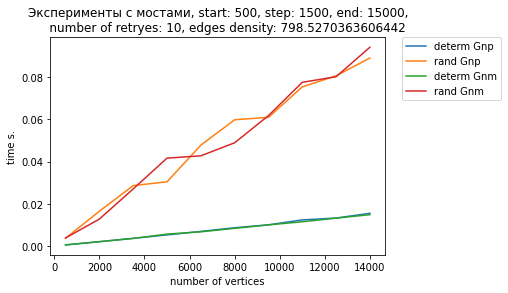

Total time: 14.635659217834473


In [33]:
print(f"Total time: {check_time(plot_bridges, lambda n: n**(3/10))}")

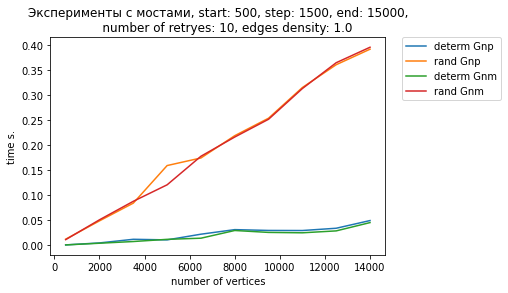

Total time: 54.73671293258667


In [34]:
print(f"Total time: {check_time(plot_bridges, lambda n: n)}")

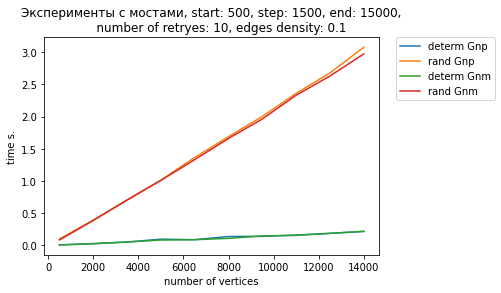

Total time: 388.995299577713


In [35]:
print(f"Total time: {check_time(plot_bridges, lambda n: 10*n)}")

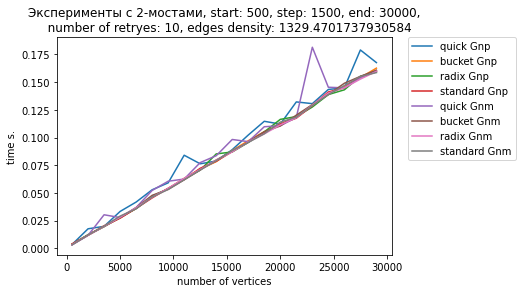

Total time: 148.5253348350525


In [ ]:
print(f"Total time: {check_time(plot_2bridges, lambda n: n**(3/10))}")

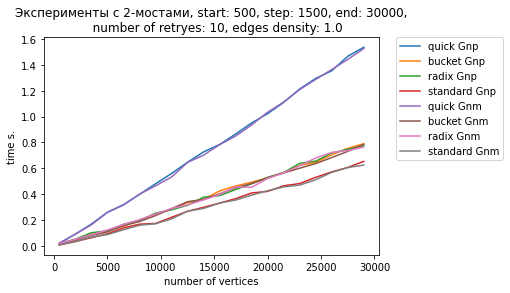

Total time: 777.8805260658264


In [ ]:
print(f"Total time: {check_time(plot_2bridges, lambda n: n)}")